## Tutorial 6 - Tiltrotor eVTOL Aircraft Simulation
Welcome to this tutorial on simulating a tiltrotor eVTOL aircraft using RCAIDE. This guide will walk you through the code, explain its components, and highlight where modifications can be made to customize the simulation for different vehicle designs.

---

## Header and Imports


The **Imports** section is divided into two parts: simulation-specific libraries and general-purpose Python libraries.

The **RCAIDE Imports** section includes the core modules needed for the simulation. These libraries provide specialized classes and tools for building, analyzing, and running aircraft models.


In [1]:
''' 
# Stopped_Rotor_EVTOL.py
# 
# Created: May 2019, M Clarke
#          Sep 2020, M. Clarke 

'''
#----------------------------------------------------------------------
#   Imports
# ---------------------------------------------------------------------
import RCAIDE
from RCAIDE.Framework.Core import Units 
from RCAIDE.Library.Methods.Geometry.Planform                                  import segment_properties,wing_segmented_planform   
from RCAIDE.Library.Methods.Weights.Correlation_Buildups.Propulsion            import compute_motor_weight
from RCAIDE.Library.Methods.Propulsors.Converters.DC_Motor                     import design_motor
from RCAIDE.Library.Methods.Propulsors.Converters.Rotor                        import design_prop_rotor  
from RCAIDE.Library.Methods.Weights.Physics_Based_Buildups.Electric            import converge_physics_based_weight_buildup 
from RCAIDE.Library.Methods.Weights.Moment_of_Inertia                          import compute_aircraft_moment_of_inertia
from RCAIDE.Library.Methods.Weights.Center_of_Gravity                          import compute_vehicle_center_of_gravity
from RCAIDE.Library.Plots                                                      import * 
from RCAIDE import  load 
from RCAIDE import  save  

import os
import numpy as np 
from copy import deepcopy
import matplotlib.pyplot as plt 
import  pickle


Matplotlib created a temporary cache directory at /var/folders/r4/4h9x29hj6f95kyhjsltxc6_00000gn/T/matplotlib-8z8wc_f2 because the default path (/Users/aidanmolloy/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


## Vehicle Setup

The **`vehicle_setup`** function defines the baseline configuration of the aircraft. This section builds the vehicle step-by-step by specifying its components, geometric properties, and high-level parameters.

---

### 1. Creating the Vehicle Instance

The setup begins by creating a vehicle instance and assigning it a **tag**. The tag is a unique string identifier used to reference the vehicle during analysis or in post-processing steps.

---

### 2. Defining High-Level Vehicle Parameters

The high-level parameters describe the aircraft’s key operational characteristics, such as:

- **Maximum Takeoff Weight**: The heaviest allowable weight of the aircraft for safe flight.
- **Operating Empty Weight**: The aircraft weight without fuel, passengers, or payload.
- **Payload**: The weight of cargo and passengers.
- **Max Zero Fuel Weight**: The maximum weight of the aircraft excluding fuel.

Units for these parameters can be converted automatically using the `Units` module to ensure consistency and reduce errors.

---

### 3. Defining the Landing Gear

Landing gear parameters, such as the number of main and nose wheels, are set for the aircraft. While not used in this tutorial, these values can be applied in advanced analyses, such as **ground loads** or **noise prediction**.

---

### 4. Main Wing Setup

The main wing is added using the **`Main_Wing`** class. This designation ensures that the primary lifting surface is recognized correctly by the analysis tools. Key properties of the wing include:

- **Area**: The total wing surface area.
- **Span**: The length of the wing from tip to tip.
- **Aspect Ratio**: A ratio of span to average chord, determining wing efficiency.
- **Segments**: Divisions of the wing geometry (e.g., root and tip sections).
- **Control Surfaces**: High-lift devices like flaps and ailerons, defined by span fractions and deflections.

---

### 5. Horizontal and Vertical Stabilizers

The stabilizers provide stability and control for the aircraft:

- **Horizontal Stabilizer**: Defined using the `Horizontal_Tail` class. It follows a similar setup to the main wing but acts as a stabilizing surface.
- **Vertical Stabilizer**: Defined using the `Vertical_Tail` class, with an additional option to designate the tail as a **T-tail** for weight calculations.

---

### 6. Fuselage Definition

The fuselage is modeled by specifying its geometric parameters, such as:

- **Length**: The overall length of the aircraft body.
- **Width**: The widest part of the fuselage cross-section.
- **Height**: The height of the fuselage.

These values influence drag calculations and overall structural weight.

---

### 7. Energy Network

The **energy network** models the propulsion system. The energy network determines the engine’s thrust, bypass ratio, and fuel type. These parameters are essential for performance and fuel efficiency analyses.


---

In [2]:

# ----------------------------------------------------------------------
#   Build the Vehicle
# ----------------------------------------------------------------------
def vehicle_setup() : 

    ospath                                = os.path.abspath(os.path.join('Notebook'))
    separator                             = os.path.sep
    rel_path = os.path.dirname(ospath) + separator + '..' + separator + '..' + separator + 'Regressions' + separator + 'Vehicles' + separator
    
    
    # ------------------------------------------------------------------
    #   Initialize the Vehicle
    # ------------------------------------------------------------------    
    vehicle                                   = RCAIDE.Vehicle()
    vehicle.tag                               = 'Tiltrotor'
    vehicle.configuration                     = 'eVTOL'

    # ------------------------------------------------------------------
    #   Vehicle-level Properties
    # ------------------------------------------------------------------    
    # mass properties
    vehicle.mass_properties.takeoff              = 2177
    vehicle.mass_properties.operating_empty      = 2177      
    vehicle.mass_properties.max_takeoff          = 2177             
    vehicle.mass_properties.center_of_gravity    = [[2.0144,   0.  ,  0. ]]      
    vehicle.reference_area                       = 10.39
    vehicle.flight_envelope.ultimate_load        = 5.7   
    vehicle.flight_envelope.positive_limit_load  = 3.  
    vehicle.passengers                           = 5

    # ------------------------------------------------------------------    
    # WINGS                                    
    # ------------------------------------------------------------------    
    # WING PROPERTIES           
    wing                                      = RCAIDE.Library.Components.Wings.Main_Wing()
    wing.tag                                  = 'main_wing'  
    wing.aspect_ratio                         = 9.11 
    wing.sweeps.quarter_chord                 = 0.0  
    wing.thickness_to_chord                   = 0.15
    wing.taper                                = 0.650 
    wing.spans.projected                      = 9.736 
    wing.chords.root                          = 1.57 
    wing.total_length                         = 1.57  
    wing.chords.tip                           = 0.66 
    wing.chords.mean_aerodynamic              = 1.069 
    wing.dihedral                             = 0   * Units.degrees  
    wing.areas.reference                      = 10.39 * 2  
    wing.areas.wetted                         = 10.39 * 2   
    wing.areas.exposed                        = 10.39 * 2   
    wing.twists.root                          = 0   * Units.degrees  
    wing.twists.tip                           = 0   * Units.degrees   
    wing.origin                               = [[ 1.778,0 , 1.0 ]]
    wing.aerodynamic_center                   = [ 1.8 ,0 , 1.0 ]    
    wing.winglet_fraction                     = 0.0  
    wing.symmetric                            = True
    wing.vertical                             = False
                                              
    # Segment                                              
    segment                                   = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                               = 'Section_1'   
    segment.percent_span_location             = 0.0
    segment.twist                             = 4.0  * Units.degrees
    segment.root_chord_percent                = 1 
    segment.dihedral_outboard                 = 8.  * Units.degrees
    segment.sweeps.quarter_chord              = 0. * Units.degrees 
    segment.thickness_to_chord                = 0.15 
    wing.append_segment(segment)                           
                                              
    # Segment                                               
    segment                                   = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                               = 'Section_2'    
    segment.percent_span_location             = 0.4875
    segment.twist                             = 4.0  * Units.degrees
    segment.root_chord_percent                = 0.6496
    segment.dihedral_outboard                 = 0. * Units.degrees
    segment.sweeps.quarter_chord              = 0. * Units.degrees
    segment.thickness_to_chord                = 0.135
    wing.append_segment(segment)                                 
                                              
    # Segment                                              
    segment                                   = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                               = 'Section_5'   
    segment.percent_span_location             = 1.0
    segment.twist                             = 0. 
    segment.root_chord_percent                = 0.42038
    segment.dihedral_outboard                 = 0.  * Units.degrees 
    segment.sweeps.quarter_chord              = 0.  * Units.degrees 
    segment.thickness_to_chord                = 0.12
    wing.append_segment(segment)   

    # compute reference properties 
    wing_segmented_planform(wing, overwrite_reference = True ) 
    wing = segment_properties(wing)
    vehicle.reference_area        = wing.areas.reference  
    wing.areas.wetted             = wing.areas.reference  * 2 
    wing.areas.exposed            = wing.areas.reference  * 2 

    # control surfaces ------------------------------------------- 
    flap                          = RCAIDE.Library.Components.Wings.Control_Surfaces.Flap()
    flap.tag                      = 'flap'
    flap.span_fraction_start      = 0.2
    flap.span_fraction_end        = 0.5
    flap.deflection               = 0.0 * Units.degrees 
    flap.chord_fraction           = 0.20
    wing.append_control_surface(flap)  
    

    aileron                       = RCAIDE.Library.Components.Wings.Control_Surfaces.Aileron()
    aileron.tag                   = 'aileron'
    aileron.span_fraction_start   = 0.7
    aileron.span_fraction_end     = 0.9 
    aileron.deflection            = 0.0 * Units.degrees
    aileron.chord_fraction        = 0.2
    wing.append_control_surface(aileron)     
    
        
    # add to vehicle 
    vehicle.append_component(wing)  
                  
                                              
    # WING PROPERTIES                         
    wing                                      = RCAIDE.Library.Components.Wings.Horizontal_Tail() 
    wing.aspect_ratio                         = 4.27172 
    wing.sweeps.quarter_chord                 = 22.46  * Units.degrees 
    wing.thickness_to_chord                   = 0.15 
    wing.spans.projected                      = 3.6
    wing.chords.root                          = 1.193 
    wing.total_length                         = 1.193 
    wing.chords.tip                           = 0.535 
    wing.taper                                = 0.44  
    wing.chords.mean_aerodynamic              = 0.864 
    wing.dihedral                             = 45.0 * Units.degrees 
    wing.areas.reference                      = 4.25 * 2 
    wing.areas.wetted                         = 4.25 * 2 
    wing.areas.exposed                        = 4.25 * 2 
    wing.twists.root                          = 0 * Units.degrees 
    wing.twists.tip                           = 0 * Units.degrees 
    wing.origin                               = [[ 5.167, 0.0 ,0.470 ]]
    wing.aerodynamic_center                   = [  5.267,  0., 0.470  ]  
    wing.winglet_fraction                     = 0.0 
    wing.symmetric                            = True    

    elevator                              = RCAIDE.Library.Components.Wings.Control_Surfaces.Elevator()
    elevator.tag                          = 'elevator'
    elevator.span_fraction_start          = 0.6
    elevator.span_fraction_end            = 0.9
    elevator.deflection                   = 0.0  * Units.deg
    elevator.chord_fraction               = 0.4
    wing.append_control_surface(elevator)       
    

    rudder                                = RCAIDE.Library.Components.Wings.Control_Surfaces.Rudder()
    rudder.tag                            = 'rudder'
    rudder.span_fraction_start            = 0.1
    rudder.span_fraction_end              = 0.5
    rudder.deflection                     = 0.0  * Units.deg
    rudder.chord_fraction                 = 0.4
    wing.append_control_surface(rudder) 

    # add to vehicle
    vehicle.append_component(wing)    
  
    # ---------------------------------------------------------------   
    # FUSELAGE                
    # ---------------------------------------------------------------   
    # FUSELAGE PROPERTIES
    fuselage                                    = RCAIDE.Library.Components.Fuselages.Fuselage()
    fuselage.tag                                = 'fuselage' 
    fuselage.seats_abreast                      = 2.  
    fuselage.seat_pitch                         = 3.  
    fuselage.fineness.nose                      = 0.88   
    fuselage.fineness.tail                      = 1.13   
    fuselage.lengths.nose                       = 0.5  
    fuselage.lengths.tail                       = 1.5
    fuselage.lengths.cabin                      = 4.46 
    fuselage.lengths.total                      = 6.46
    fuselage.width                              = 4.65 * Units.feet
    fuselage.heights.maximum                    = 4.65 * Units.feet      # change 
    fuselage.heights.at_quarter_length          = 3.75 * Units.feet      # change 
    fuselage.heights.at_wing_root_quarter_chord = 4.65 * Units.feet      # change 
    fuselage.heights.at_three_quarters_length   = 4.26 * Units.feet      # change 
    fuselage.areas.wetted                       = 236. * Units.feet**2   # change 
    fuselage.areas.front_projected              = 0.14 * Units.feet**2   # change 
    fuselage.effective_diameter                 = 1.276     # change 
    fuselage.differential_pressure              = 0. 
    
    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_0'    
    segment.percent_x_location                  = 0.0 
    segment.percent_z_location                  = 0.     # change  
    segment.height                              = 0.049 
    segment.width                               = 0.032 
    fuselage.append_segment(segment)                     
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_1'   
    segment.percent_x_location                  = 0.026  
    segment.percent_z_location                  = 0.00849
    segment.height                              = 0.481 
    segment.width                               = 0.553 
    fuselage.append_segment(segment)           
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_2'   
    segment.percent_x_location                  = 0.074
    segment.percent_z_location                  = 0.02874
    segment.height                              = 1.00
    segment.width                               = 0.912 
    fuselage.append_segment(segment)                     
                                                
    # Segment                                            
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_3'   
    segment.percent_x_location                  = 0.161  
    segment.percent_z_location                  = 0.04348   
    segment.height                              = 1.41
    segment.width                               = 1.174  
    fuselage.append_segment(segment)                     
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_4'   
    segment.percent_x_location                  = 0.284 
    segment.percent_z_location                  = 0.05435 
    segment.height                              = 1.62
    segment.width                               = 1.276  
    fuselage.append_segment(segment)              
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_5'   
    segment.percent_x_location                  = 0.531 
    segment.percent_z_location                  = 0.0510 
    segment.height                              = 1.409
    segment.width                               = 1.121 
    fuselage.append_segment(segment)                     
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_6'   
    segment.percent_x_location                  = 0.651
    segment.percent_z_location                  = 0.05636 
    segment.height                              = 1.11
    segment.width                               = 0.833
    fuselage.append_segment(segment)                  
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_7'   
    segment.percent_x_location                  = 0.773
    segment.percent_z_location                  = 0.06149 
    segment.height                              = 0.78
    segment.width                               = 0.512 
    fuselage.append_segment(segment)                  
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_8'   
    segment.percent_x_location                  = 1.
    segment.percent_z_location                  = 0.07352  
    segment.height                              = 0.195  
    segment.width                               = 0.130 
    fuselage.append_segment(segment)                   
                                                
    vehicle.append_component(fuselage)  



    #------------------------------------------------------------------------------------------------------------------------------------
    # ########################################################  Energy Network  ######################################################### 
    #------------------------------------------------------------------------------------------------------------------------------------
    # define network
    network                                                = RCAIDE.Framework.Networks.Electric() 
    network.charging_power                                 = 1000
   
    #==================================================================================================================================== 
    # Tilt Rotor Bus 
    #====================================================================================================================================          
    bus                           = RCAIDE.Library.Components.Energy.Distributors.Electrical_Bus()
    bus.tag                       = 'bus'
    bus.number_of_battery_modules =  4

    #------------------------------------------------------------------------------------------------------------------------------------  
    # Bus Battery
    #------------------------------------------------------------------------------------------------------------------------------------ 
    battery_module                                                    = RCAIDE.Library.Components.Powertrain.Sources.Battery_Modules.Lithium_Ion_NMC() 
    battery_module.tag                                                = 'bus_battery'
    battery_module.electrical_configuration.series                    = 35
    battery_module.electrical_configuration.parallel                  = 100                
    battery_module.geometrtic_configuration.normal_count              = 140
    battery_module.geometrtic_configuration.parallel_count            = 25
    battery_module.geometrtic_configuration.stacking_rows             = 2
    
                       # starboard   | port        | front  | rear 
    modules_origins = [[1.8, 2.0,1.0 ],[1.8, -2.0, 1.0  ],[0.5, 0.0, 0.0 ],[3.5, 0.0, 0.0]]  
    orientation     = [[0, 0.0, np.pi],[0, 0.0, np.pi ],[0, 0.0, 0 ],[0, 0.0,0 ]]   
    for m_i in range(bus.number_of_battery_modules):
        module =  deepcopy(battery_module)
        module.tag = 'nmc_module_' + str(m_i+1) 
        module.origin = [modules_origins[m_i]] 
        module.orientation_euler_angles  = orientation[m_i]  
        bus.battery_modules.append(module) 
    bus.initialize_bus_properties()    
    
    #------------------------------------------------------------------------------------------------------------------------------------  
    # Lift Propulsors 
    #------------------------------------------------------------------------------------------------------------------------------------    
     
    # Define Lift Propulsor Container 
    propulsor                                = RCAIDE.Library.Components.Propulsors.Electric_Rotor()
    propulsor.tag                            = 'propulsor'       
              
    # Electronic Speed Controller           
    prop_rotor_esc                                = RCAIDE.Library.Components.Energy.Modulators.Electronic_Speed_Controller()
    prop_rotor_esc.efficiency                     = 0.95    
    prop_rotor_esc.tag                            = 'prop_rotor_esc_1'  
    propulsor.electronic_speed_controller         = prop_rotor_esc  
    
    # Lift Rotor Design
    g                                             = 9.81                                    # gravitational acceleration   
    Hover_Load                                    = vehicle.mass_properties.takeoff*g *1.1  # hover load   

    prop_rotor                                    = RCAIDE.Library.Components.Powertrain.Converters.Prop_Rotor()   
    prop_rotor.tag                                = 'prop_rotor'   
    prop_rotor.tip_radius                         = 3/2
    prop_rotor.hub_radius                         = 0.15 * prop_rotor.tip_radius
    prop_rotor.number_of_blades                   = 4

    prop_rotor.hover.design_altitude              = 40 * Units.feet  
    prop_rotor.hover.design_thrust                = Hover_Load/6
    prop_rotor.hover.design_freestream_velocity   = np.sqrt(prop_rotor.hover.design_thrust/(2*1.2*np.pi*(prop_rotor.tip_radius**2)))
    
    prop_rotor.oei.design_altitude                = 40 * Units.feet  
    prop_rotor.oei.design_thrust                  = Hover_Load/5  
    prop_rotor.oei.design_freestream_velocity     = np.sqrt(prop_rotor.oei.design_thrust/(2*1.2*np.pi*(prop_rotor.tip_radius**2)))
    
    prop_rotor.cruise.design_altitude             = 1500 * Units.feet
    prop_rotor.cruise.design_thrust               = 3150 / 6
    prop_rotor.cruise.design_freestream_velocity  = 130.* Units['mph']      
    
    airfoil                                       = RCAIDE.Library.Components.Airfoils.Airfoil()   
    airfoil.coordinate_file                       =  rel_path + 'Airfoils' + separator + 'NACA_4412.txt'
    airfoil.polar_files                           = [rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_50000.txt' ,
                                                     rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_100000.txt' ,
                                                     rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_200000.txt' ,
                                                     rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_500000.txt' ,
                                                     rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_1000000.txt',
                                                     rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_3500000.txt',
                                                     rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_5000000.txt',
                                                     rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_7500000.txt' ]
    prop_rotor.append_airfoil(airfoil)                
    prop_rotor.airfoil_polar_stations             = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]    
    prop_rotor.fidelity                           = "Momentum_Theory"   
    design_prop_rotor(prop_rotor) 
    propulsor.rotor =  prop_rotor 
    
    
    #------------------------------------------------------------------------------------------------------------------------------------               
    # Lift Rotor Motor  
    #------------------------------------------------------------------------------------------------------------------------------------    
    prop_rotor_motor                         = RCAIDE.Library.Components.Powertrain.Converters.DC_Motor()
    prop_rotor_motor.efficiency              = 0.95
    prop_rotor_motor.nominal_voltage         = bus.voltage * 0.75
    prop_rotor_motor.prop_rotor_radius       = prop_rotor.tip_radius 
    prop_rotor_motor.no_load_current         = 0.01 
    prop_rotor_motor.rotor_radius            = prop_rotor.tip_radius
    prop_rotor_motor.design_torque           = (prop_rotor.hover.design_thrust * np.sqrt(prop_rotor.hover.design_thrust/(2*1.2*np.pi*(prop_rotor.tip_radius**2)))) /prop_rotor.hover.design_angular_velocity 
    prop_rotor_motor.angular_velocity        = prop_rotor.hover.design_angular_velocity/prop_rotor_motor.gear_ratio  
    design_motor(prop_rotor_motor) 
    prop_rotor_motor.mass_properties.mass    = compute_motor_weight(prop_rotor_motor)     
    propulsor.motor                          = prop_rotor_motor
     

    #------------------------------------------------------------------------------------------------------------------------------------               
    # Lift Rotor Nacelle
    #------------------------------------------------------------------------------------------------------------------------------------     
    nacelle                           = RCAIDE.Library.Components.Nacelles.Nacelle() 
    nacelle.length                    = 0.45
    nacelle.diameter                  = 0.3 
    nacelle.flow_through              = False
    
    
    propulsor.nacelle            =  nacelle  

    # Front Rotors Locations 
    origins =[[0.208, -1.848,  1.195],[0.208, 1.848,  1.195],
              [1.505,5.000,1.320],[1.505,-5.000,1.320],
              [  5.318, 1.848,   2.282],[   5.318, -1.848,   2.282]] 
     
    assigned_propulsor_list = []    
    for i in range(len(origins)): 
        propulsor_i                                       = deepcopy(propulsor)
        propulsor_i.tag                                   = 'prop_rotor_propulsor_' + str(i + 1)
        propulsor_i.rotor.tag                             = 'prop_rotor_' + str(i + 1) 
        propulsor_i.rotor.origin                          = [origins[i]]  
        propulsor_i.motor.tag                             = 'prop_rotor_motor_' + str(i + 1)   
        propulsor_i.motor.origin                          = [origins[i]]  
        propulsor_i.electronic_speed_controller.tag       = 'prop_rotor_esc_' + str(i + 1)  
        propulsor_i.electronic_speed_controller.origin    = [origins[i]]  
        propulsor_i.nacelle.tag                           = 'prop_rotor_nacelle_' + str(i + 1)  
        propulsor_i.nacelle.origin                        = [origins[i]]   
        network.propulsors.append(propulsor_i)   
        assigned_propulsor_list.append(propulsor_i.tag) 
    bus.assigned_propulsors = [assigned_propulsor_list]

    #------------------------------------------------------------------------------------------------------------------------------------  
    # Additional Bus Loads
    #------------------------------------------------------------------------------------------------------------------------------------            
    # Payload   
    payload                         = RCAIDE.Library.Components.Systems.Avionics()
    payload.power_draw              = 10. # Watts 
    payload.mass_properties.mass    = 1.0 * Units.kg
    bus.payload                     = payload 
                             
    # Avionics                            
    avionics                        = RCAIDE.Library.Components.Systems.Avionics()
    avionics.power_draw             = 10. # Watts  
    avionics.mass_properties.mass   = 1.0 * Units.kg
    bus.avionics                    = avionics    
   
    network.busses.append(bus)
     
    # append energy network 
    vehicle.append_energy_network(network)  
 
    #------------------------------------------------------------------------------------------------------------------------------------
    # ##################################   Determine Vehicle Mass Properties Using Physic Based Methods  ################################ 
    #------------------------------------------------------------------------------------------------------------------------------------   
    converged_vehicle, breakdown = converge_physics_based_weight_buildup(vehicle)  
    print(breakdown)

    # ------------------------------------------------------------------
    #   CG Location
    # ------------------------------------------------------------------    
    _ , _ =  compute_vehicle_center_of_gravity(converged_vehicle) 
    CG_location  = converged_vehicle.mass_properties.center_of_gravity
    
    # ------------------------------------------------------------------
    #   Operating Aircraft MOI
    # ------------------------------------------------------------------    
    _, _ = compute_aircraft_moment_of_inertia(converged_vehicle, CG_location)    

    return converged_vehicle 
 

## Configurations Setup

The **`configs_setup`** function defines the different vehicle configurations (referred to as **configs**) used during the simulation. Configurations allow for modifications to the baseline vehicle, such as altering control surface settings, without redefining the entire vehicle.

---

### 1. Base Configuration

The **base configuration** serves as the foundation for all other configurations. It is defined to match the baseline vehicle created in the `vehicle_setup` function. Configurations in RCAIDE are created as **containers** using **RCAIDE Data classes**. These classes provide additional functionality, such as the ability to **append** new configurations or modifications.

---

### 2. Cruise Configuration

The **cruise configuration** demonstrates that new configurations can inherit properties directly from existing configurations (e.g., the base config). This avoids redundancy and ensures consistency across configurations.

- The cruise configuration typically reflects the clean flight condition, with no high-lift devices like flaps or slats deployed.
  
---



## 3. Remaining Configurations

The remaining configurations, such as **climb**, **approach**, and **hover**, follow a similar pattern:

- Hover Climb
- Hover-to-Cruise
- Approach
- Hover

Each configuration is built upon the previous one or the base configuration, ensuring modularity and easy customization.



---

In [3]:
            
 
def configs_setup(vehicle):
    '''
    The configration set up below the scheduling of the nacelle angle and vehicle speed.
    Since one prop_rotor operates at varying flight conditions, one must perscribe  the 
    pitch command of the prop_rotor which us used in the variable pitch model in the analyses
    Note: low pitch at take off & low speeds, high pitch at cruise
    '''
    # ------------------------------------------------------------------
    #   Initialize Configurations
    # ------------------------------------------------------------------ 
    configs = RCAIDE.Library.Components.Configs.Config.Container() 
    base_config                                                       = RCAIDE.Library.Components.Configs.Config(vehicle)
    base_config.tag                                                   = 'base'     
    configs.append(base_config) 
 
    # ------------------------------------------------------------------
    #   Hover Climb Configuration
    # ------------------------------------------------------------------
    config                                                 = RCAIDE.Library.Components.Configs.Config(vehicle)
    config.tag                                             = 'vertical_climb'
    vector_angle                                           = 90.0 * Units.degrees    
    for network in  config.networks:  
        for propulsor in  network.propulsors:
            propulsor.rotor.orientation_euler_angles =  [0, vector_angle, 0]
    configs.append(config)

    # ------------------------------------------------------------------
    #    
    # ------------------------------------------------------------------
    config                                            = RCAIDE.Library.Components.Configs.Config(vehicle)
    vector_angle                                      = 75.0  * Units.degrees   
    config.tag                                        = 'vertical_transition' 
    for network in  config.networks:  
        for propulsor in  network.propulsors:
            propulsor.rotor.orientation_euler_angles =  [0, vector_angle, 0]
            propulsor.rotor.pitch_command   = propulsor.rotor.hover.design_pitch_command * 0.5 
    configs.append(config) 

    # ------------------------------------------------------------------
    #   Hover-to-Cruise Configuration
    # ------------------------------------------------------------------
    config                                            = RCAIDE.Library.Components.Configs.Config(vehicle)
    config.tag                                        = 'low_speed_climb_transition'
    vector_angle                                      = 45.0  * Units.degrees   
    for network in  config.networks:  
        for propulsor in  network.propulsors:
            propulsor.rotor.orientation_euler_angles =  [0, vector_angle, 0]
            propulsor.rotor.pitch_command     = propulsor.rotor.cruise.design_pitch_command * 0.5  
    configs.append(config) 

    # ------------------------------------------------------------------
    #   Hover-to-Cruise Configuration
    # ------------------------------------------------------------------
    config                                            = RCAIDE.Library.Components.Configs.Config(vehicle)
    config.tag                                        = 'high_speed_climb_transition'
    vector_angle                                      = 5.0  * Units.degrees   
    for network in  config.networks:  
        for propulsor in  network.propulsors:
            propulsor.rotor.orientation_euler_angles =  [0, vector_angle, 0]
            propulsor.rotor.pitch_command     = propulsor.rotor.cruise.design_pitch_command  
    configs.append(config) 
 
    # ------------------------------------------------------------------
    #   Cruise Configuration
    # ------------------------------------------------------------------
    config                                            = RCAIDE.Library.Components.Configs.Config(vehicle)
    config.tag                                        = 'cruise'   
    vector_angle                                      = 0.0 * Units.degrees   
    for network in  config.networks:  
        for propulsor in  network.propulsors:
            propulsor.rotor.orientation_euler_angles =  [0, vector_angle, 0]
            propulsor.rotor.pitch_command   = propulsor.rotor.cruise.design_pitch_command  
    configs.append(config)
    
    # ------------------------------------------------------------------
    #   Approach Configuration
    # ------------------------------------------------------------------
    config                                            = RCAIDE.Library.Components.Configs.Config(vehicle)
    config.tag                                        = 'approach_transition'    
    vector_angle                                      = 85.0  * Units.degrees   
    for network in  config.networks:  
        for propulsor in  network.propulsors:
            propulsor.rotor.orientation_euler_angles =  [0, vector_angle, 0] 
            propulsor.rotor.pitch_command   = propulsor.rotor.cruise.design_pitch_command * 0.75
    configs.append(config)
    
    
    # ------------------------------------------------------------------
    #   Hover Configuration
    # ------------------------------------------------------------------
    config                                            = RCAIDE.Library.Components.Configs.Config(vehicle)
    config.tag                                        = 'vertical_descent'
    vector_angle                                      = 90.0  * Units.degrees 
    for network in  config.networks:  
        for propulsor in  network.propulsors:  
            propulsor.rotor.orientation_euler_angles =  [0, vector_angle, 0]
    configs.append(config)

    return configs



## Base Analysis

The **`base_analysis`** function defines the analyses required for evaluating the aircraft. Each analysis addresses a specific aspect of the vehicle’s performance or characteristics. Below are the key analyses, their purpose, and considerations for their use.

---

### 1. Weights Analysis

The **weights analysis** calculates the distribution of the aircraft's weight across various components. This method is based on **empirical correlations** designed for **tube-and-wing transport aircraft** configurations.

- Provides a breakdown of component weights (e.g., wings, fuselage, engines).
- While informative, the results of this analysis are **not directly used** in the performance evaluation.

---

### 2. Aerodynamics Analysis

The **aerodynamics analysis** evaluates the aerodynamic performance of the aircraft. It uses RCAIDE's **fidelity zero** method:

- **Fidelity Zero**: This is RCAIDE's baseline aerodynamic analysis method, suitable for **subsonic transport aircraft**.
- Similar to aerodynamic methods found in conceptual design texts.
- Provides estimates for lift, drag, and other aerodynamic coefficients.

> Note: Higher-fidelity aerodynamic methods are available for more detailed analyses if needed.

---

### 3. Stability Analysis

The **stability analysis** calculates stability derivatives for the aircraft. While it is **not used** in the current mission setup, it can be run post-mission for checks or additional analysis.

- Like the aerodynamic method, it uses **fidelity zero** for baseline stability analysis.
- Applicable for basic stability checks of subsonic transport aircraft.

---

### 4. Energy Analysis

The **energy analysis** runs the energy network attached to the vehicle. For this turboprop-powered aircraft:

- The analysis evaluates the **turboprop energy network**.
- Ensures the propulsion system behavior, such as thrust and fuel consumption, is accounted for.

---

### 5. Planet Analysis

The **planet analysis** defines the planetary environment the vehicle operates in. This setup allows for the attachment of an atmospheric model.

---

### 6. Atmosphere Analysis

The **atmosphere analysis** sets the atmospheric conditions for the simulation. A common choice is the **US 1976 Standard Atmosphere**, which provides:

- Standard temperature, pressure, and density profiles with altitude.
- Consistent atmospheric conditions for performance evaluations.

---


In [4]:

def base_analysis(vehicle):

    # ------------------------------------------------------------------
    #   Initialize the Analyses
    # ------------------------------------------------------------------     
    analyses = RCAIDE.Framework.Analyses.Vehicle() 
    
    # ------------------------------------------------------------------
    #  Weights
    weights         = RCAIDE.Framework.Analyses.Weights.Weights_EVTOL()
    weights.vehicle = vehicle
    analyses.append(weights)

    # ------------------------------------------------------------------
    #  Aerodynamics Analysis
    aerodynamics         = RCAIDE.Framework.Analyses.Aerodynamics.Vortex_Lattice_Method() 
    aerodynamics.vehicle = vehicle 
    analyses.append(aerodynamics)
     
    # ------------------------------------------------------------------
    #  Stability Analysis
    stability         = RCAIDE.Framework.Analyses.Stability.Vortex_Lattice_Method() 
    stability.vehicle = vehicle 
    analyses.append(stability)    

    # ------------------------------------------------------------------
    #  Energy
    energy          = RCAIDE.Framework.Analyses.Energy.Energy()
    energy.vehicle = vehicle 
    analyses.append(energy)

    # ------------------------------------------------------------------
    #  Planet Analysis
    planet = RCAIDE.Framework.Analyses.Planets.Earth()
    analyses.append(planet)

    # ------------------------------------------------------------------
    #  Atmosphere Analysis
    atmosphere = RCAIDE.Framework.Analyses.Atmospheric.US_Standard_1976()
    atmosphere.features.planet = planet.features
    analyses.append(atmosphere)   

    # done!
    return analyses    




## Analyses Setup

The **`analyses_setup`** function assigns a set of analyses to each vehicle configuration. Analyses are used to evaluate the aircraft’s performance, aerodynamics, energy systems, and other characteristics for a given configuration.

---

## 1. Overview of Analyses Assignment

In this tutorial, **all configurations** share the same set of analyses. However, this function provides the flexibility to assign a unique set of analyses to any specific configuration.

---

### 2. Purpose of Analyses Assignment

The analyses ensure that the defined vehicle configurations (e.g., **cruise**, **takeoff**, **landing**) are evaluated correctly during the simulation. Each configuration can have:

- **Common Analyses**: Shared across multiple configurations for simplicity.
- **Custom Analyses**: Tailored to a specific phase of flight or performance evaluation.

---

### 3. Typical Analyses Included

The following analyses are typically assigned to each configuration:

- **Weights Analysis**: Computes weight distribution across components.
- **Aerodynamics Analysis**: Estimates lift, drag, and aerodynamic coefficients.
- **Stability Analysis**: Evaluates stability derivatives for flight control assessments.
- **Energy Analysis**: Runs the energy network (e.g., turboprop engine) for thrust and fuel performance.
- **Atmosphere Analysis**: Sets atmospheric conditions using standard atmospheric models.

By assigning these analyses, the vehicle's behavior under different configurations (e.g., **cruise**, **takeoff**, **landing**) can be comprehensively evaluated.

---

### 4. Customizing Analyses

To assign a **custom analysis set** for a specific configuration:

1. Define a new analysis function tailored to the desired evaluation.
2. Replace the default analyses for the target configuration by calling the custom function.

For example, the **takeoff configuration** might use a modified aerodynamic analysis to account for flap and slat deployment.

---

In [5]:


 
def analyses_setup(configs):

    analyses = RCAIDE.Framework.Analyses.Analysis.Container()

    # build a base analysis for each config
    for tag,config in configs.items():
        analysis = base_analysis(config)
        analyses[tag] = analysis

    return analyses


## Mission Setup

The **`mission_setup`** function defines the **mission profile** used to compute the aircraft's performance. A mission profile consists of sequential **segments** that represent different phases of flight, such as climb, cruise, and descent.

---

### 1. Mission Profile Overview

A mission profile is made up of individual flight segments. Each segment specifies the aircraft's flight conditions, such as:

- **Altitude**
- **Speed**
- **Range**
- **Time**

These segments are simulated sequentially, allowing for a detailed performance analysis of the vehicle across all phases of flight.

---

### 2. Segments in the Mission Profile

Common segments in a mission profile include:

- **Taxi**: Ground movement of the aircraft before takeoff and after landing.
- **Takeoff**: Acceleration and lift-off phase with high-lift devices deployed.
- **Climb**: Gradual ascent to cruise altitude, often with reduced flap/slat deployment.
- **Cruise**: Level flight at a constant altitude and speed for fuel-efficient operation.
- **Descent**: Controlled reduction in altitude as the aircraft prepares for landing.
- **Landing**: Final phase of flight with maximum flap and slat deployment for touchdown.

Each segment defines specific performance conditions and parameters, such as speed, altitude, and duration.


For more information on the mission solver and its implementation, refer to the relevant RCAIDE documentation.

---

In [6]:

# ----------------------------------------------------------------------
#   Define the Mission
# ----------------------------------------------------------------------
def mission_setup(analyses ):

    # ------------------------------------------------------------------
    #   Initialize the Mission
    # ------------------------------------------------------------------
    mission = RCAIDE.Framework.Mission.Sequential_Segments()
    mission.tag = 'mission'

    # unpack Segments module
    Segments = RCAIDE.Framework.Mission.Segments  
    base_segment = Segments.Segment()

    # ------------------------------------------------------------------
    #   First Climb Segment: Constant Speed, Constant Rate
    # ------------------------------------------------------------------ 
    segment                                            = Segments.Vertical_Flight.Climb(base_segment)
    segment.tag                                        = "Vertical_Climb"   
    segment.analyses.extend(analyses.vertical_climb) 
    segment.altitude_start                             = 0.0  * Units.ft  
    segment.altitude_end                               = 50.  * Units.ft   
    segment.climb_rate                                 = 500. * Units['ft/min'] 
    segment.initial_battery_state_of_charge            = 1.0 
    segment.true_course                                = 0   * Units.degree # this is the true couse of the starting value  

    # define flight dynamics to model  
    segment.flight_dynamics.force_z                    = True 

    # define flight controls  
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6']]  
    
    mission.append_segment(segment)    
    # ------------------------------------------------------------------
    #  First Transition Segment
    # ------------------------------------------------------------------ 
    segment                                               = Segments.Cruise.Constant_Acceleration_Constant_Altitude(base_segment)
    segment.tag                                           = "Vertical_Transition"  
    segment.analyses.extend( analyses.vertical_transition)   
    segment.air_speed_end                                 = 35 * Units['mph']     
    segment.acceleration                                  = 1.0
    segment.true_course                                   = 0 * Units.degree  

    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6']]  
    segment.assigned_control_variables.body_angle.active             = True 
    
    mission.append_segment(segment)
    
    # ------------------------------------------------------------------
    #   First Cruise Segment: Constant Acceleration, Constant Altitude
    # ------------------------------------------------------------------ 
    segment                          = Segments.Climb.Linear_Speed_Constant_Rate(base_segment)
    segment.tag                      = "low_speed_climb_transition" 
    segment.analyses.extend(analyses.low_speed_climb_transition) 
    segment.climb_rate               = 822. * Units['ft/min'] 
    segment.air_speed_end            = 100 * Units['mph']   
    segment.altitude_end             = 500.0 * Units.ft
    segment.true_course              = 0 * Units.degree  

    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6']]  
    segment.assigned_control_variables.body_angle.active             = True 
                                                                             
    mission.append_segment(segment)   
    
 
    # ------------------------------------------------------------------
    #   First Cruise Segment: Constant Acceleration, Constant Altitude
    # ------------------------------------------------------------------ 
    segment                           = Segments.Climb.Linear_Speed_Constant_Rate(base_segment)
    segment.tag                       = "Climb"  
    segment.analyses.extend(analyses.cruise) 
    segment.climb_rate                = 500. * Units['ft/min']
    segment.air_speed_start           = 90.   * Units.kts 
    segment.air_speed_end             = 125.  * Units['mph']   
    segment.altitude_end              = 1000.0 * Units.ft 
    segment.true_course               = 90 * Units.degree  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  =[['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6']]   
        
    segment.assigned_control_variables.body_angle.active             = True
    
    mission.append_segment(segment)

    # ------------------------------------------------------------------
    #   First Cruise Segment: Constant Acceleration, Constant Altitude
    # ------------------------------------------------------------------ 
    segment                          = Segments.Cruise.Constant_Speed_Constant_Altitude(base_segment)
    segment.tag                      = "Cruise"  
    segment.analyses.extend(analyses.cruise) 
    segment.altitude                 = 1000.0 * Units.ft
    segment.air_speed                = 125.  * Units['mph']   
    segment.distance                 = 90*Units.nmi
    segment.true_course              = 90 * Units.degree  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6']]  
    segment.assigned_control_variables.body_angle.active             = True
    mission.append_segment(segment)     
    
    # ------------------------------------------------------------------
    #    Descent Segment: Constant Acceleration, Constant Altitude
    # ------------------------------------------------------------------ 
    segment                          = Segments.Climb.Linear_Speed_Constant_Rate(base_segment)
    segment.tag                      = "Descent"  
    segment.analyses.extend(analyses.cruise)
    segment.climb_rate               = -300. * Units['ft/min']
    segment.air_speed_start          = 125.  * Units['mph'] 
    segment.air_speed_end            = 90 * Units.kts 
    segment.altitude_start           = 1000.0 * Units.ft
    segment.altitude_end             = 500.0 * Units.ft
    segment.true_course              = 90 * Units.degree  

    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6']]  
    segment.assigned_control_variables.body_angle.active             = True
    
        
    mission.append_segment(segment) 
    
        
    # ------------------------------------------------------------------
    #  Forth Transition Segment
    # ------------------------------------------------------------------ 
    segment                          = Segments.Descent.Linear_Speed_Constant_Rate(base_segment)
    segment.tag                      = "Approach_Transition"   
    segment.analyses.extend(analyses.approach_transition)  
    segment.descent_rate             = 200.  * Units['ft/min'] 
    segment.air_speed_end            = 10. * Units.kts 
    segment.altitude_end             = 50.0 * Units.ft
    segment.true_course              = 180 * Units.degree  

    # define flight dynamics to model 
    segment.flight_dynamics.force_x  = True  
    segment.flight_dynamics.force_z  = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6']]  
    segment.assigned_control_variables.body_angle.active             = True
        
    mission.append_segment(segment)
    
    #------------------------------------------------------------------------------------------------------------------------------------ 
    # Vertical Descent 
    #------------------------------------------------------------------------------------------------------------------------------------ 
    segment                                                         = Segments.Vertical_Flight.Descent(base_segment)
    segment.tag                                                     = "Vertical_Descent" 
    segment.analyses.extend( analyses.vertical_descent)                
    segment.altitude_end                                            = 0.   * Units.ft  
    segment.descent_rate                                            = 300. * Units['ft/min'] 
    segment.true_course                                             = 180 * Units.degree  
                  
    # define flight dynamics to model              
    segment.flight_dynamics.force_z                                  = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6']]  
            
    mission.append_segment(segment)      
    
    return mission


## Missions Setup

The `missions_setup` function is responsible for setting up a list of missions. This allows multiple missions to be incorporated if desired, but only one is used here.

1. **Initialize Missions Object**: It creates an empty `Missions` object from the `RCAIDE.Framework.Mission` module.
2. **Tag the Mission**: It assigns the tag `'base_mission'` to the provided `mission` object. This tag is used to identify the mission.
3. **Add Mission to List**: It adds the tagged `mission` to the `Missions` object.
4. **Return Missions Object**: Finally, it returns the `Missions` object, which now contains the tagged mission.

---

In [7]:
def missions_setup(mission): 
 
    missions         = RCAIDE.Framework.Mission.Missions()
    
    # base mission 
    mission.tag  = 'base_mission'
    missions.append(mission)
 
    return missions

## Plot Mission

The last function in this file is used to plot the performance results from the mission evaluation. The results shown are not an exhaustive list of RCAIDE outputs, and custom plotting routines can be created.

In [8]:

def plot_results(results):
    # Plots fligh conditions 
    plot_flight_conditions(results) 
    
    # Plot arcraft trajectory
    plot_flight_trajectory(results)
    
    # Plot Aerodynamic Coefficients
    plot_aerodynamic_coefficients(results)  
     
    # Plot Aircraft Stability
    plot_longitudinal_stability(results) 
    
    # Plot Aircraft Electronics 
    plot_battery_temperature(results)
    plot_battery_cell_conditions(results) 
    plot_battery_degradation(results) 
    plot_electric_propulsor_efficiencies(results) 
    
    # Plot Propeller Conditions 
    plot_rotor_conditions(results) 
    plot_disc_and_power_loading(results)  
    return

In [9]:
def save_aircraft_geometry(geometry,filename): 
    pickle_file  = filename + '.pkl'
    with open(pickle_file, 'wb') as file:
        pickle.dump(geometry, file) 
    return 

In [10]:
def load_aircraft_geometry(filename):  
    load_file = filename + '.pkl' 
    with open(load_file, 'rb') as file:
        results = pickle.load(file) 
    return results

In [11]:

def load_rotor(filename):
    rotor =  load(filename)
    return rotor

In [12]:
def save_rotor(rotor, filename):
    save(rotor, filename)
    return

Inputs
[ 0.15        2.          1.          0.075       0.52359878  1.
  0.5         0.52359878  0.5         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.08485043]
Inputs
[ 0.150001    2.          1.          0.075       0.52359878  1.
  0.5         0.52359878  0.5         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.08484908]
Inputs
[ 0.15        1.999999    1.          0.075       0.52359878  1.
  0.5         0.52359878  0.5         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.08485047]
Inputs
[ 0.15        2.          1.000001    0.075       0.52359878  1.
  0.5         0.52359878  0.5         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.08485048]
Inputs
[ 0.15        2.          1.          0.075001    0.52359878  1.
  0.5         0.52359878  0.5         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.0848496]
Inputs
[ 0.15        2.          1.          0.075       0.52359978  1.
  0.5         0.52359878  0.5         0.5         0.52359878  0.3
 -0.52359878]
Obj


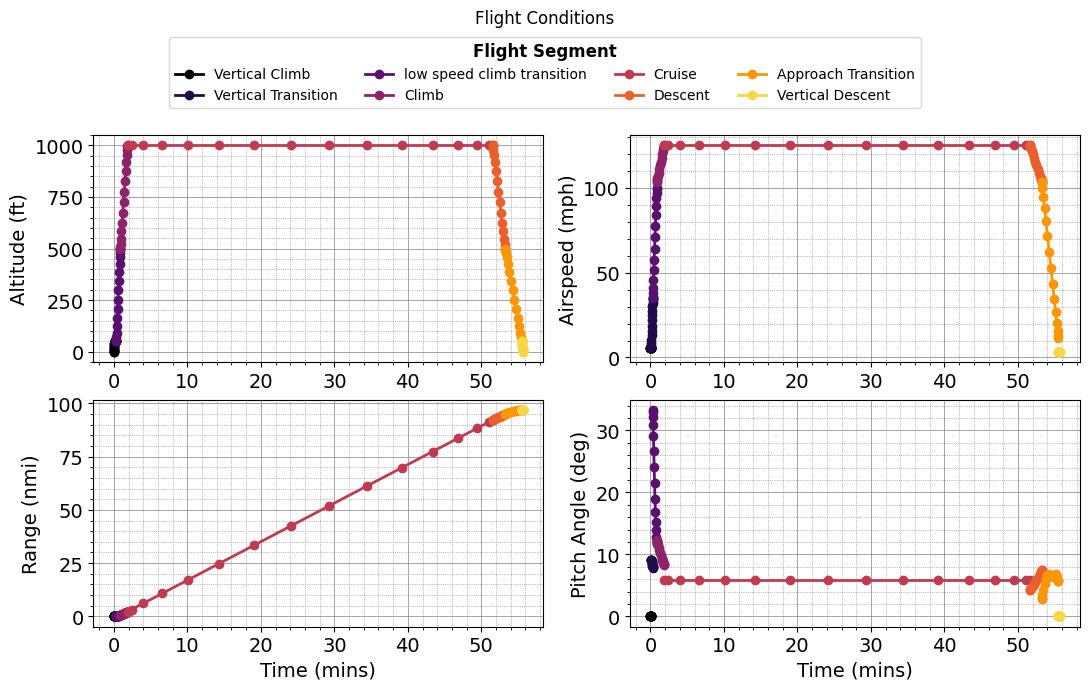

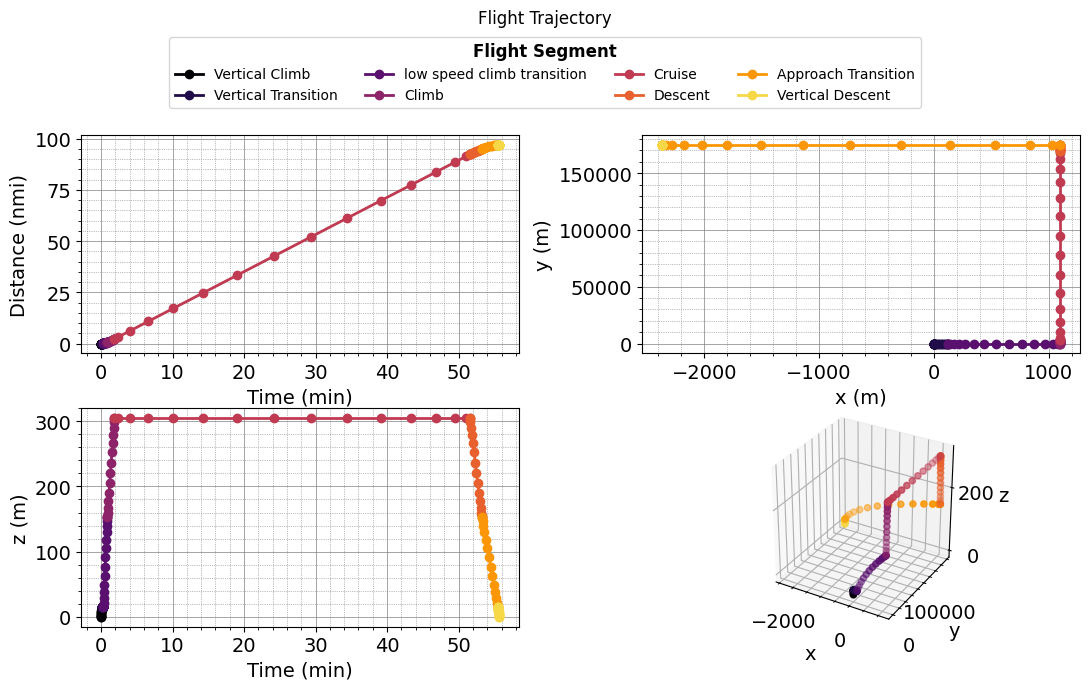

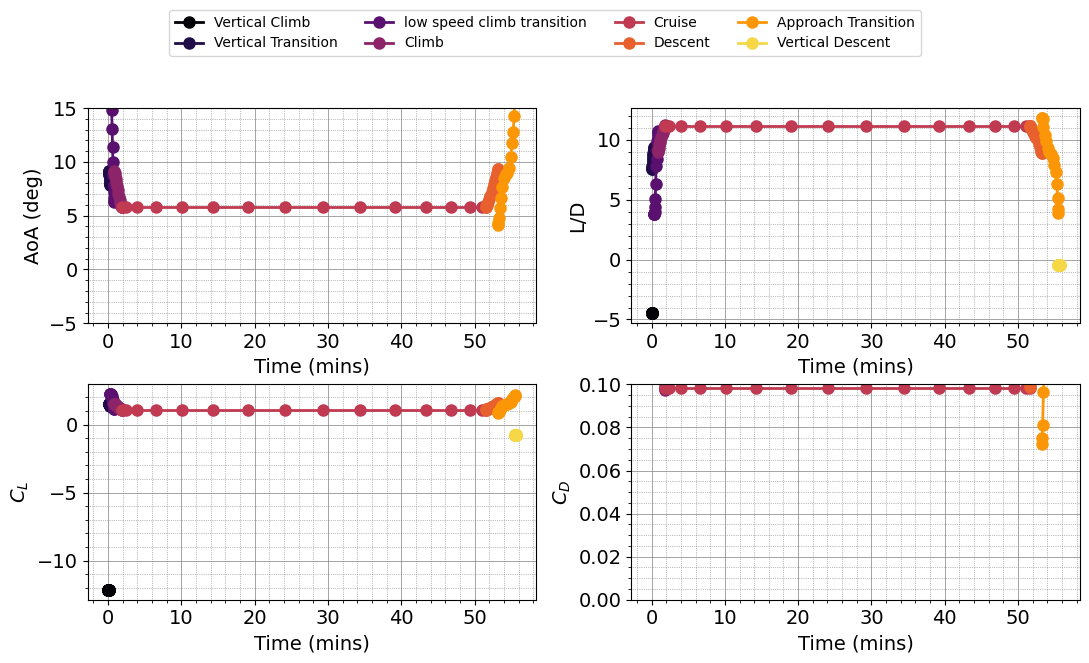

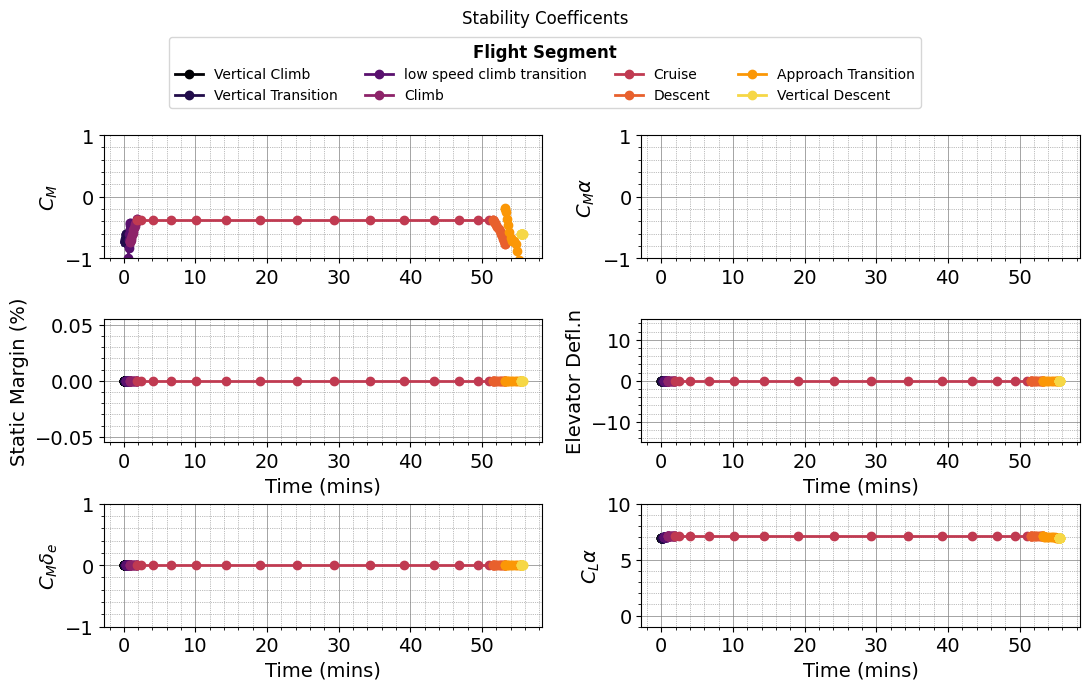

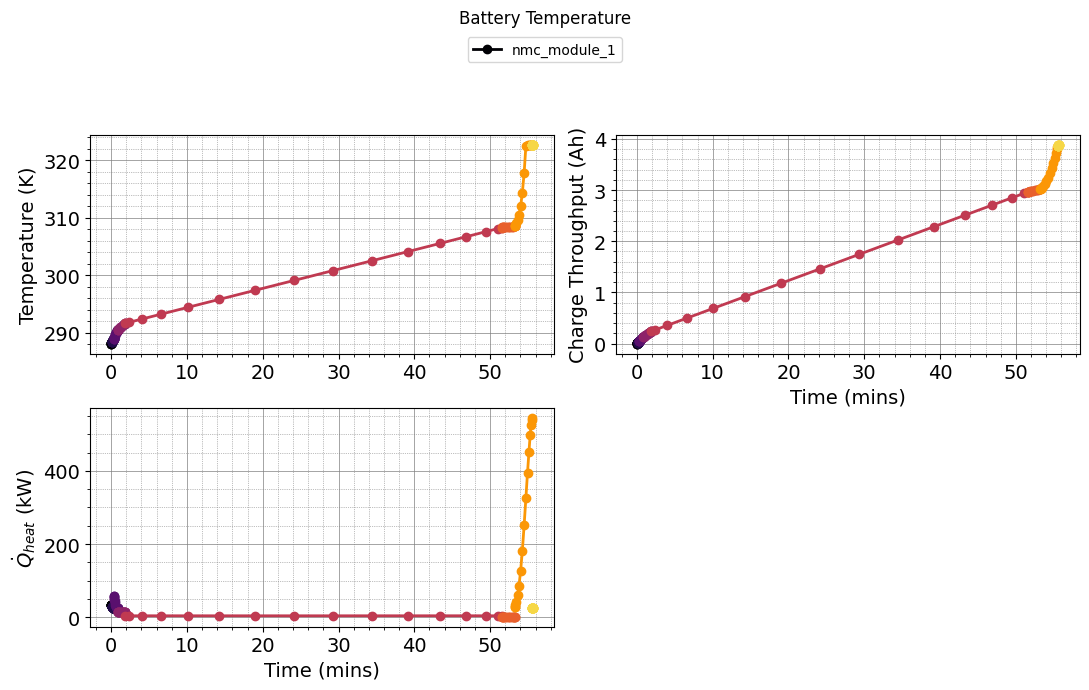

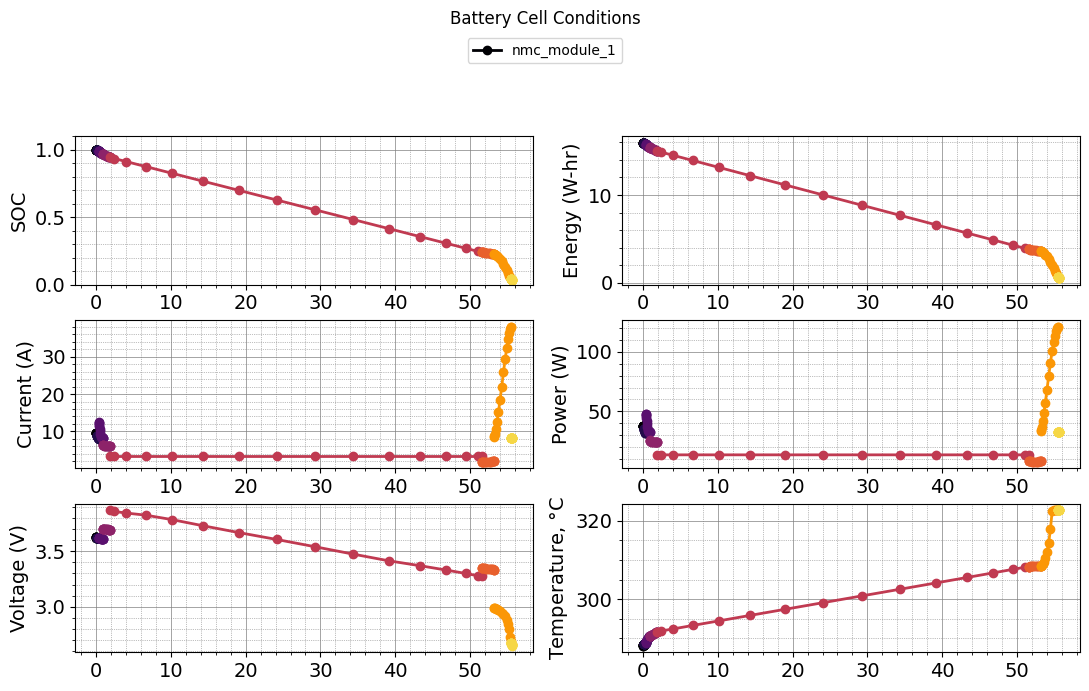

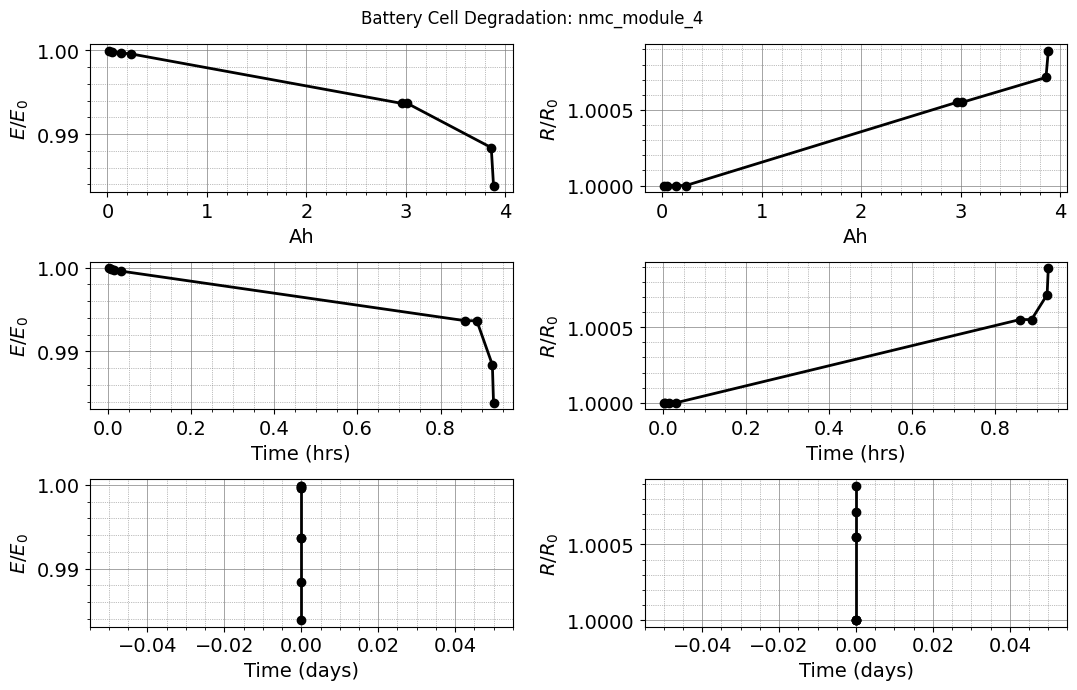

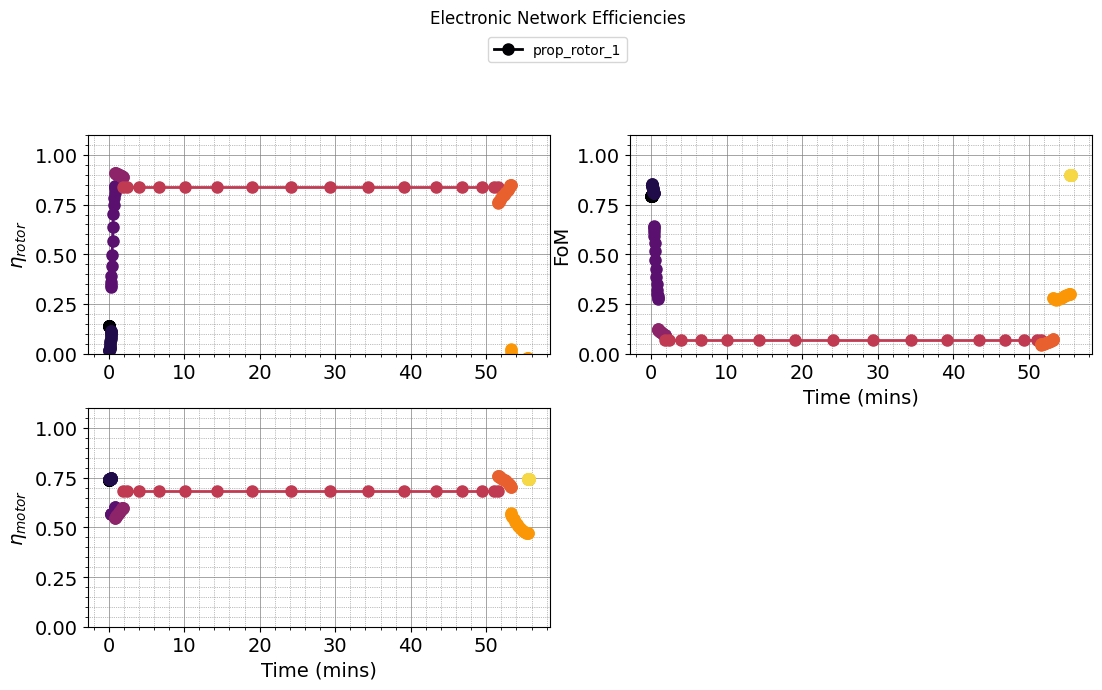

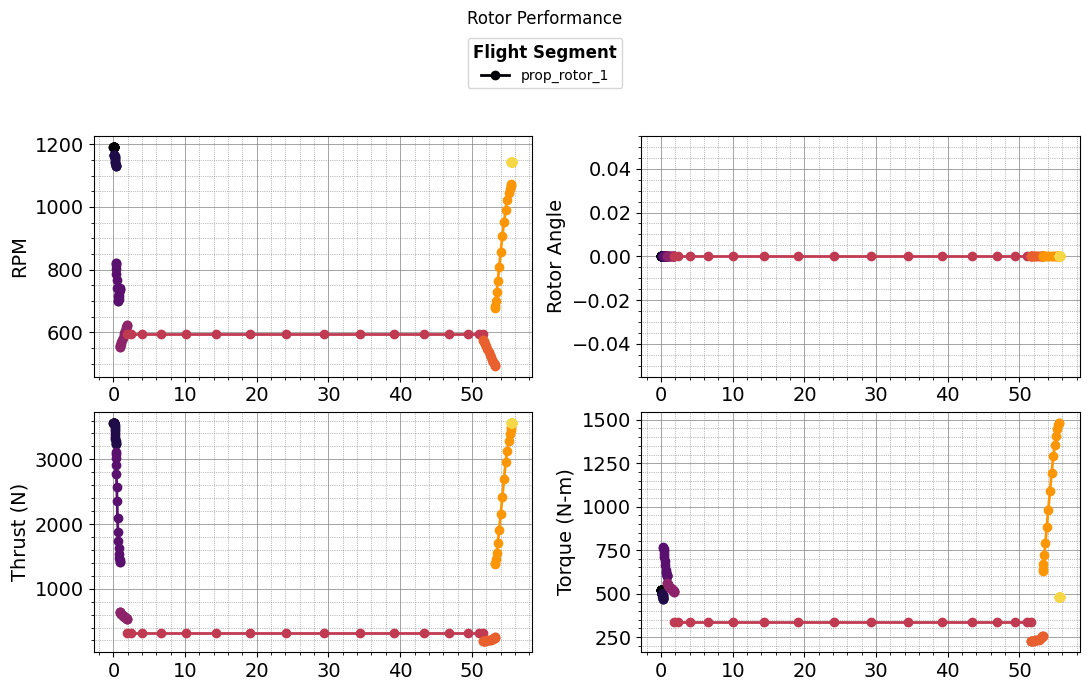

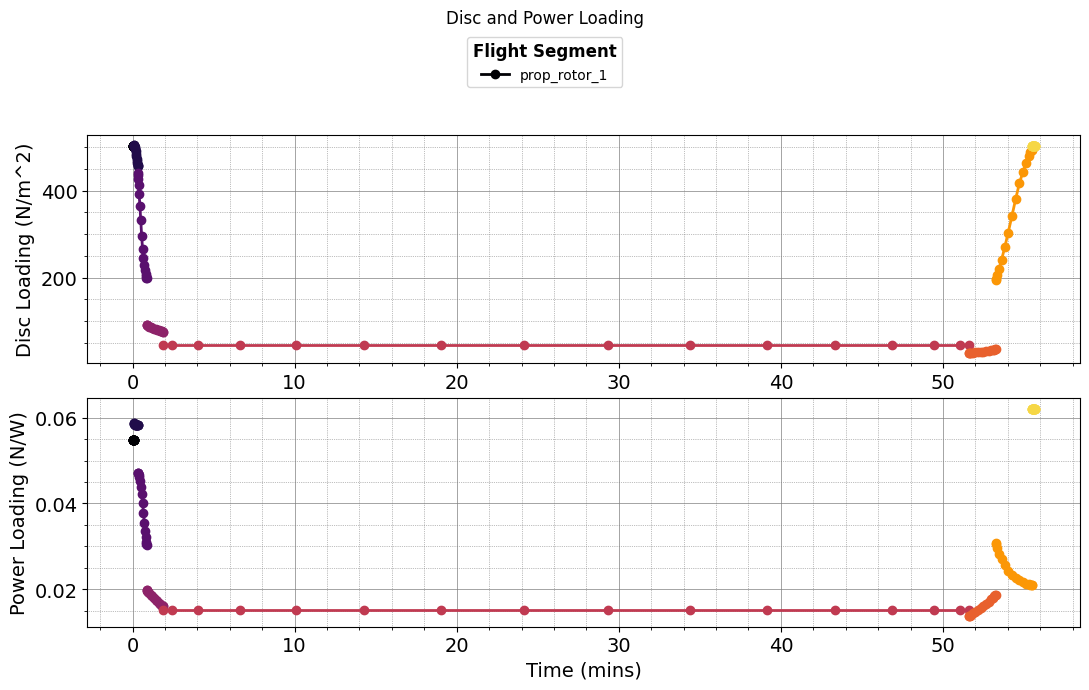

In [13]:
# vehicle data  
vehicle  = vehicle_setup() 

# Set up configs
configs  = configs_setup(vehicle)

# vehicle analyses
analyses = analyses_setup(configs)

# mission analyses
mission  = mission_setup(analyses) 
missions = missions_setup(mission) 
    
results = missions.base_mission.evaluate() 
    
# plot the results 
plot_results(results) 

## plot vehicle 
#plot_3d_vehicle(vehicle, 
                #min_x_axis_limit            = -5,
                #max_x_axis_limit            = 15,
                #min_y_axis_limit            = -10,
                #max_y_axis_limit            = 10,
                #min_z_axis_limit            = -10,
                #max_z_axis_limit            = 10,
                #show_figure                 = False 
                #) 